In [113]:
# import packages
#analysis
import mdtraj
import numpy as np
import MDAnalysis as mda

#visualization
import nglview

#openMM sims
import openmm
from openff.units import Quantity, unit
from openmm import unit as openmm_unit
from pdbfixer import PDBFixer
from openmm.app import StateDataReporter
from openff.toolkit import ForceField, Molecule, Topology

%env OMP_NUM_THREADS=6

env: OMP_NUM_THREADS=6


# Prepare Solvated Ligand-Receptor Complex

## Ligand

In [114]:
#visualize
ligand_path = 'SHP099_1.sdf'
view = nglview.show_structure_file(ligand_path)
view

NGLWidget()

CC1([NH3+])CCN(c2cnc(-c3cccc(Cl)c3Cl)c(N)n2)CC1


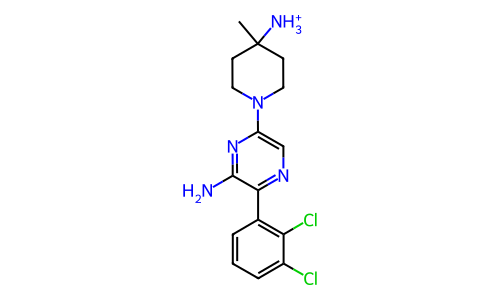

In [115]:
#prepare ligand for openff

# Load from SDF file
ligand = Molecule.from_file(ligand_path)

# Print out a SMILES code for the ligand
print(ligand.to_smiles(explicit_hydrogens=False))

# Visualize molecule
ligand.visualize(show_all_hydrogens=False)

## Receptor

In [116]:
# receptor
receptor_path = '5ehr_prepared.pdb'

view = nglview.show_structure_file(receptor_path)
view.add_line(selection="(not protein)")
view


NGLWidget()

In [117]:
# insert ligand into receptor (code obtained/modified from openFF tutorial page)
# https://docs.openforcefield.org/en/latest/examples/openforcefield/openff-toolkit/toolkit_showcase/toolkit_showcase.html

receptor_topology = Topology.from_pdb(receptor_path)

def insert_lig_to_recep(    topology: Topology,
    insert: Molecule,
    radius: Quantity = 1.5 * unit.angstrom,
    keep: list[Molecule] = [],
) -> Topology:
    
    # New topology in list
    new_top_mols = []

    #Grab positions from openff Molecule object
    insert_coordinates = insert.conformers[0][None,:,:]
    for molecule in topology.molecules:
        if any(keep_mol.is_isomorphic_with(molecule) for keep_mol in keep):
            new_top_mols.append(molecule)
            continue
        molecule_coordinates = molecule.conformers[0][:,None,:]
        diff_matrix = molecule_coordinates - insert_coordinates

        working_unit = unit.nanometer
        distance_matrix = (np.linalg.norm(diff_matrix.m_as(working_unit),axis=-1) * working_unit)

        if distance_matrix.min() > radius:
            new_top_mols.append(molecule)
        else:
            print(f'Removed {molecule.to_smiles()} molecule')
    new_top_mols.append(insert)

    new_top = Topology.from_molecules(new_top_mols)
    new_top.box_vectors = topology.box_vectors
    return new_top
    
complex_top = insert_lig_to_recep(receptor_topology, ligand)    

In [118]:
# visualize complex

def visualize(topology):
    '''Visualize a topology with nglview'''
    from io import StringIO

    with StringIO() as f:
        topology.to_file(file=f)
        pdb_str = f.getvalue()
    return nglview.show_text(pdb_str)

# Create the widget. By default, proteins are shown as a cartoon and unrecognised ligands with a ball-and-stick model
view = visualize(complex_top)

# Add a licorice/stick representation for everything except the protein
view.add_line(selection="(not protein)")

# Make the ions clearer by drawing their vdW surfaces
view.add_spacefill(selection=":.NA or :.CL")

# Render the widget
view

NGLWidget()

In [46]:
# save unsolvated complex to pdb file
complex_top.to_file('complex.pdb')

In [119]:
# load in topology from our previously saved pdb file
# note that we need unique_molecules=[ligand] w/ ligand specified in section
top = Topology.from_pdb('complex.pdb',unique_molecules=[ligand])

#specify forcefields
sage_ff14sb = ForceField("openff-2.2.0.offxml", "ff14sb_off_impropers_0.0.4.offxml")

# make interchange for conversion to openMM
interchange = sage_ff14sb.create_interchange(top)



In [121]:
# openmm
from openmmforcefields.generators import SMIRNOFFTemplateGenerator

# grab topology from interchange to use in openMM
openmm_top = interchange.topology.to_openmm()
openmm_positions : openmm.unit.Quantity = interchange.positions.to_openmm()

# set up simulations in openMM
modeller = openmm.app.Modeller(openmm_top,openmm_positions)
forcefield = openmm.app.ForceField('amber14-all.xml', 'amber14/tip3pfb.xml')

# since ligands usually aren't recognized for forcefields use SMIRNOFF
smirnoff = SMIRNOFFTemplateGenerator(molecules=ligand)
forcefield.registerTemplateGenerator(smirnoff.generator)

# add solvent molecules around our complex
modeller.addSolvent(forcefield, padding = 1.0 * openmm.unit.nanometer,ionicStrength=0.1*openmm.unit.molar)

# save initial configuration
openmm.app.pdbfile.PDBFile.writeFile(modeller.topology,modeller.getPositions(),'solvated_complex_init.pdb')

# # specficy integrator
# integrator = openmm.LangevinIntegrator(
#     300 * openmm_unit.kelvin,
#     1 / openmm_unit.picosecond,
#     0.002 * openmm_unit.picoseconds,
# )

# # create system and simulation
# system = forcefield.createSystem(modeller.topology)
# simulation = openmm.app.Simulation(openmm_top,system,integrator)

In [122]:
# load in structure and prepare parameters

from openmmforcefields.generators import SMIRNOFFTemplateGenerator
from openmm.app import *
from openmm import *
from openmm.unit import *
from sys import stdout


pdb = pdbfile.PDBFile('solvated_complex_init.pdb')
forcefield = ForceField('amber14-all.xml', 'amber14/tip3pfb.xml')
smirnoff = SMIRNOFFTemplateGenerator(molecules=ligand)
forcefield.registerTemplateGenerator(smirnoff.generator)
integrator = openmm.LangevinIntegrator(
    300 * openmm_unit.kelvin,
    1 / openmm_unit.picosecond,
    0.002 * openmm_unit.picoseconds,
)

system = forcefield.createSystem(pdb.topology,nonbondedMethod=PME)
system.addForce(MonteCarloBarostat(1*bar, 300*kelvin))
simulation = Simulation(pdb.topology,system,integrator)
simulation.context.setPositions(pdb.positions)




In [123]:
# First do energy minimization

def describe_state(state: openmm.State, name: str = 'State'):
    max_force = max(np.sqrt(v.x**2 + v.y**2 + v.z**2) for v in state.getForces())
    print(f"{name} has energy {round(state.getPotentialEnergy()._value, 2)} kJ/mol " f"With maximum force {round(max_force, 2)} kJ/(mol nm)")


describe_state(
    simulation.context.getState(
        getEnergy=True,
        getForces=True,
    ),"Original state",
)
simulation.minimizeEnergy()

describe_state(
    simulation.context.getState(getEnergy=True, getForces=True),
    "Minimized state",
)


Original state has energy -672153.71 kJ/mol With maximum force 729886.07 kJ/(mol nm)
Minimized state has energy -1768615.58 kJ/mol With maximum force 2839.24 kJ/(mol nm)


In [124]:
# Now run MD simulations


# Load state if restarting here
# simulation.loadCheckpoint(eqb_state.chk')


#set reporters
simulation.reporters.append(pdbreporter.PDBReporter('eqb_run.pdb',20000))
simulation.reporters.append(StateDataReporter('eqb_run.dat', 20000, step=True,
        potentialEnergy=True, kineticEnergy=True, temperature=True))

#run for n steps - I did 10 ns eqb and 20 ns production
simulation.step(5000000)

#save state for restart
simulation.saveCheckpoint('eqb_state.chk')

# Analysis

In [2]:
# Analysis
from __future__ import print_function
import matplotlib.pyplot as plt
import itertools
import mdtraj.testing
import MDAnalysis as mda
import MDAnalysis.transformations as trans

/home/kmei94/miniconda3/envs/CompChem/lib/python3.12/site-packages/Bio/Application/__init__.py:39: BiopythonDeprecationWarning: The Bio.Application modules and modules relying on it have been deprecated.

Due to the on going maintenance burden of keeping command line application
wrappers up to date, we have decided to deprecate and eventually remove these
modules.

We instead now recommend building your command line and invoking it directly
with the subprocess module.
  warnings.warn(


Text(0, 0.5, 'Potential Energy (kj/mol)')

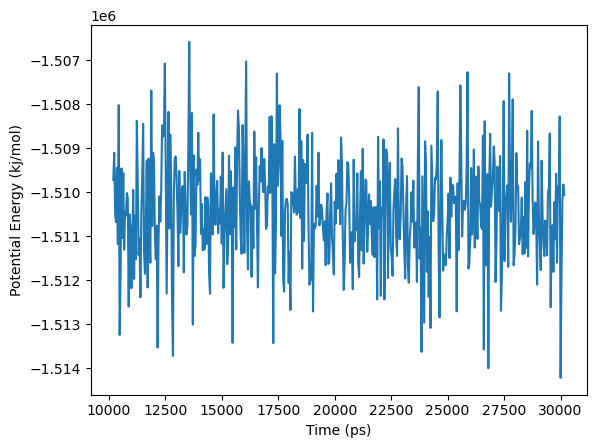

In [125]:
# Check for drifts in potential energy and temperature
energy = np.loadtxt('prod_output.dat',delimiter=',')
plt.plot(energy[:,0]*0.002,energy[:,1])
plt.xlabel('Time (ps)')
plt.ylabel('Potential Energy (kj/mol)')

Text(0, 0.5, 'Temperature (K)')

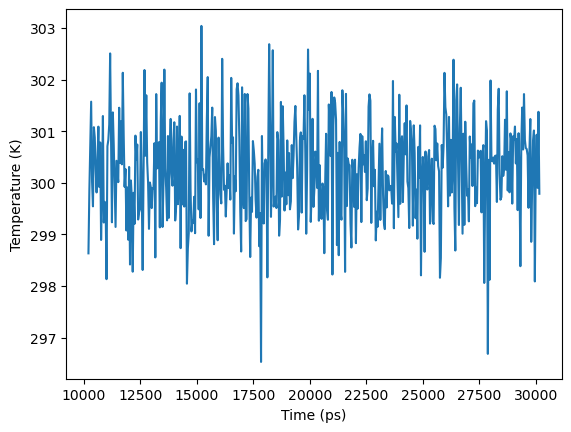

In [126]:
plt.plot(energy[:,0]*0.002,energy[:,3])
plt.xlabel('Time (ps)')
plt.ylabel('Temperature (K)')

In [127]:
# load in universe with MDAnalysis
u = mda.Universe('prod_output.pdb',dt=40)

/home/kmei94/miniconda3/envs/CompChem/lib/python3.12/site-packages/MDAnalysis/topology/PDBParser.py:295: UserWarning: PDB file is missing resid information.  Defaulted to '1'
  warnings.warn("PDB file is missing resid information.  "


In [128]:
# specify box dimensions and center complex

protein = u.select_atoms('protein')
not_protein = u.select_atoms('not protein')
transforms = [trans.boxdimensions.set_dimensions([99.623,99.623,99.623,90,90,90]),
              trans.center_in_box(protein),
              trans.wrap(not_protein)]

u.trajectory.add_transformations(*transforms)

In [129]:
#visualize trajectory - omit water molecules for visualization purposes

comp = u.select_atoms('protein','resname UNK')
view = nglview.show_mdanalysis(comp)
view.add_representation("ball-and-stick",selection='resname UNK')
view.center()
view

NGLWidget(max_frame=499)

In [130]:
# RMSD

from MDAnalysis.analysis import rms, align

bb = u.select_atoms('backbone')
u.trajectory[0]
rmsd_analysis = rms.RMSD(u, select='backbone', groupselections=['name CA'])
rmsd_analysis.run()

<>:7: SyntaxWarning: invalid escape sequence '\A'
<>:7: SyntaxWarning: invalid escape sequence '\A'
/tmp/ipykernel_3534/2062040994.py:7: SyntaxWarning: invalid escape sequence '\A'
  plt.ylabel('RMSD ($\AA$) ')


Text(0, 0.5, 'RMSD ($\\AA$) ')

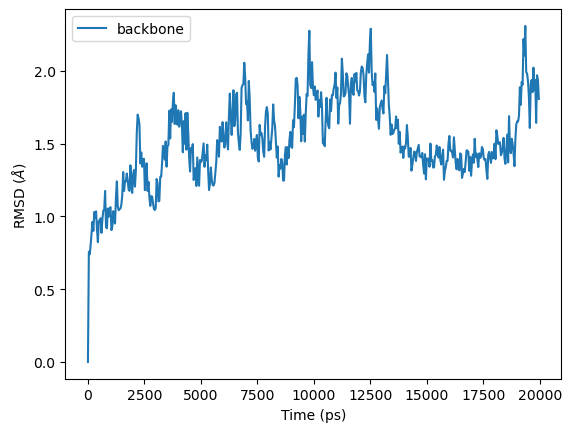

In [133]:
result = rmsd_analysis.results.rmsd

plt.plot(result[:,1],result[:,2],label='backbone')

plt.legend()
plt.xlabel('Time (ps)')
plt.ylabel('RMSD ($\AA$) ')

In [134]:
# RMSF

# get avg config
average = align.AverageStructure(u, u, select='protein and name CA',
                                 ref_frame=0).run()
ref = average.results.universe

# align to avg
aligner = align.AlignTraj(u, ref,
                          select='protein and name CA',
                          in_memory=True).run()

# look at C_{alpha} carbons
c_alphas = u.select_atoms('protein and name CA')
R = rms.RMSF(c_alphas).run()

<>:4: SyntaxWarning: invalid escape sequence '\A'
<>:4: SyntaxWarning: invalid escape sequence '\A'
/tmp/ipykernel_3534/526957787.py:4: SyntaxWarning: invalid escape sequence '\A'
  plt.ylabel('RMSF ($\AA$)')


Text(0, 0.5, 'RMSF ($\\AA$)')

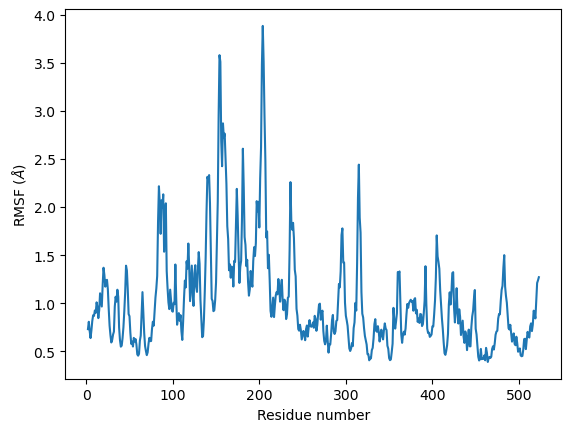

In [136]:
# plot RMSD vs residue number
plt.plot(c_alphas.resids, R.results.rmsf)
plt.xlabel('Residue number')
plt.ylabel('RMSF ($\AA$)')

In [137]:
# Add RMSF value to topology for visualization purposes

u.add_TopologyAttr('tempfactors') # add empty attribute for all atoms
protein = u.select_atoms('protein') # select protein atoms
for residue, r_value in zip(protein.residues, R.results.rmsf):
    residue.atoms.tempfactors = r_value



In [138]:
# 3D visualization of complex with bfactor
comp = u.select_atoms('protein','resname UNK')
view = nglview.show_mdanalysis(comp)
view.add_representation("lines",selection="resname UNK")
view.update_representation(color_scheme='bfactor')
view

NGLWidget(max_frame=499)

# TBD - Scoring functions